# Assignment 1: This is the title of the assignment

Authors:  
Lina Hagberg  
Ella Villför  

## Imports

ToDo: 
* Rensa bland viderona 
* Dela upp i träning 
* .MOV funkar ej

In [2]:
# It is recommended to start with general import statements
from utility_functions import *
import ultralytics
ultralytics.checks()
import cv2
from ultralytics import YOLO
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

Ultralytics 8.3.88 🚀 Python-3.10.13 torch-2.6.0 CPU (Apple M1)
Setup complete ✅ (8 CPUs, 16.0 GB RAM, 217.9/228.3 GB disk)


## Load data

This section should load the raw dataset for the task.  
Remember to use relative paths to load any files in the notebook.

In [79]:
# Data to calssify: barbell biceps curl, bench press, deadlift, plank, pull up, push up, shoulder press and squat

# Load the YOLOv8 model
model = YOLO('yolov8n-pose.pt', verbose=False)

# Path to the main dataset folder
dataset_path = "raw_data" 
output_csv = "keypoints_dataset.csv"
num_keypoints = 17 * 2  # 17 keypoints 34 total value
num_frames = 200

X = []
Y = []

# Iterate over each subfolder (exercise category)
for exercise_folder in os.listdir(dataset_path):
    if exercise_folder == ".DS_Store":
        continue
    
    exercise_path = os.path.join(dataset_path, exercise_folder)
    print(f"Processing: {exercise_path}")

    
    # Ensure it's a directory
    if not os.path.isdir(exercise_path):
        continue
    
    # Iterate over each video in the exercise folder
    for video_file in os.listdir(exercise_path):
        video_path = os.path.join(exercise_path, video_file)
        
        # Ensure it's a video file (basic check)
        if not video_file.lower().endswith((".mp4", ".mov")):
            continue
        
        cap = cv2.VideoCapture(video_path)
        keypoints_list = []

        # Loop through the video frames
        while cap.isOpened():
            # Read a frame from the video
            success, frame = cap.read()

            if not success:
                break

            # Run YOLOv8 tracking on the frame, persisting tracks between frames
            results = model.track(frame, persist=True, tracker ='bytetrack.yaml', conf=0.05, classes=0, verbose=False)

            # Extract keypoints (Handle cases where no person is detected)
            if results[0].keypoints is not None:
                # Takes the most confident person (fisrt person in list)
                keypoints = results[0].keypoints.xy.cpu().numpy()[0].flatten()
            else:
                keypoints = np.zeros(num_keypoints)  # Fill with zeros if no keypoints detected

            # Ensure keypoints are always 34 values
            if len(keypoints) > num_keypoints:
                print(f"Warning: Expected {num_keypoints} keypoints, got {len(keypoints)}. Only keeping 34 first - {video_file}")
                keypoints = keypoints[:num_keypoints]  # Trim to match expected length
                
            elif len(keypoints) < num_keypoints:
                print(f"Warning: Expected {num_keypoints} keypoints, got {len(keypoints)}.Filling with zeros - {video_file}")
                keypoints = np.pad(keypoints, (0, num_keypoints - len(keypoints)), 'constant')

            # Append to DataFrame
            keypoints_list.append(keypoints)

        cap.release()

        keypoints_list = np.array(keypoints_list)
        
        if len(keypoints_list) < num_frames:
            # Padding
            keypoints_list_adj = np.pad(keypoints_list, ((0, num_frames - keypoints_list.shape[0]), (0, 0)),  'constant')

            #keypoints_list = np.pad(keypoints_list, (0, num_frames - len(keypoints_list)), 'constant')
        elif len(keypoints_list) > num_frames:
            # Trim
            keypoints_list_adj = keypoints_list[:num_frames]
            
        X.append(keypoints_list_adj)
        Y.append(exercise_folder)

        if exercise_folder == "plank" and keypoints_list.shape[0] > num_frames*2:
            keypoints_list_adj = keypoints_list[keypoints_list.shape[0]-num_frames:keypoints_list.shape[0]]
            X.append(keypoints_list_adj)
            Y.append(exercise_folder)



# Convert to NumPy arrays
X_numpy = np.array(X)  # Shape: (num_videos, 200, 34)
Y_numpy = np.array(Y)  # Labels

print(f"Shape X: {X_numpy.shape}")  # Should be (num_videos, 200, 34)
print(f"Shape Y: {Y_numpy.shape}")  # Should be (num_videos,)


Processing: raw_data/plank
Shape X: (11, 200, 34)
Shape Y: (11,)


In [80]:
# Save data to CSV

def saveToCsv(filename, X, Y):
    temp = []

    for i in range(Y.shape[0]):
        if Y[i] == filename:
            temp.append(X[i,:,:])

    # Convert list of arrays into a NumPy array
    temp_numpy = np.array(temp)  # Shape: (num_squat_samples, 200, 29)

    # Reshape into a 2D format for CSV (flattening each video sequence)
    num_samples, num_frames, num_features = temp_numpy.shape
    temp_reshaped = temp_numpy.reshape(num_samples, num_frames * num_features)

    # Convert to Pandas DataFrame
    temp_df = pd.DataFrame(temp_reshaped)

    # Save to CSV
    temp_df.to_csv(f"{filename}.csv", index=False)

    print("CSV file saved successfully")

saveToCsv("plank", X_numpy, Y_numpy)






CSV file saved successfully


In [81]:
# Load csv

def load_csv(filename, num_frames):

    # Load the CSV file
    load_df = pd.read_csv(f"processed_data/{filename}")

    # Convert DataFrame to NumPy array
    load_numpy = load_df.to_numpy()  # Shape: (num_samples, 5800)

    # Reshape back to original (samples, 200, 29)
    num_samples = load_numpy.shape[0]
    num_features = 34

    X_load = load_numpy.reshape(num_samples, num_frames, num_features)
    name = filename.replace(".csv", "")
    Y_load = np.array([name] * X_load.shape[0])

    print(f"Restored Shape: {X_load.shape}")  # Expected: (num_samples, 200, 29)

    return X_load, Y_load

X = []
Y = []

for exercise in os.listdir("processed_data"):
    x_temp, y_temp = load_csv(exercise, num_frames)
    X.append(x_temp)
    Y.append(y_temp)

X_numpy = np.concatenate(X) # Stack along samples axis
Y_numpy = np.concatenate(Y) # Labels

print(f"Shape X_numpy: {X_numpy.shape}")  # Should be (num_videos, 200, 34)
print(f"Shape Y_numpy: {Y_numpy.shape}")  # Should be (num_videos,)


Restored Shape: (11, 200, 34)
Restored Shape: (29, 200, 34)
Restored Shape: (32, 200, 34)
Shape X_numpy: (72, 200, 34)
Shape Y_numpy: (72,)


In [82]:

X_body = X_numpy[:,:,8:]
print(f"Shape X: {X_body.shape}")  # Should be (num_videos, 200, 26)

Shape X: (72, 200, 26)


In [83]:
unique_values, counts = np.unique(Y_numpy, return_counts=True)

print(f"Unique values: {unique_values}")
print(f"Count: {counts}")

Unique values: ['deadlift' 'plank' 'squat']
Count: [32 11 29]


In [ ]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

## Task 1: This is the title of task 1

This section should contain the solution of task 1.

It is mandatory to maintain the headings for each task.  
OPTIONALLY, you can use one level down (###) to organize subsessions of the assignments.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from sklearn.model_selection import train_test_split
import pandas as pd

# Convert labels to categorical (one-hot encoding)
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(Y_numpy)  # Convert string labels to numbers
y = tf.keras.utils.to_categorical(y)  # One-hot encode labels

# Define LSTM model
model = Sequential([
    Masking(mask_value=0.0,input_shape=(X_body.shape[1], X_body.shape[2])),
    LSTM(128, return_sequences=True, ),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(y.shape[1], activation='softmax')  # Output layer
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
X_train, X_test, y_train, y_test = train_test_split(X_body, y, test_size=0.3, random_state=42)
print(f"Shape X: {X_train.shape}")  # Should be (num_videos, 200, 34)
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

# Print results
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")



Shape X: (50, 200, 26)
Epoch 1/10
2/2 [==============================] - 6s 1s/step - loss: 1.0889 - accuracy: 0.4200 - val_loss: 1.0628 - val_accuracy: 0.5455
Epoch 2/10
2/2 [==============================] - 0s 183ms/step - loss: 1.0054 - accuracy: 0.5800 - val_loss: 1.0394 - val_accuracy: 0.5000
Epoch 3/10
2/2 [==============================] - 0s 198ms/step - loss: 0.9156 - accuracy: 0.6200 - val_loss: 0.9877 - val_accuracy: 0.5909
Epoch 4/10
2/2 [==============================] - 0s 184ms/step - loss: 0.8331 - accuracy: 0.7600 - val_loss: 0.9678 - val_accuracy: 0.5909
Epoch 5/10
2/2 [==============================] - 0s 192ms/step - loss: 0.7630 - accuracy: 0.8400 - val_loss: 0.9314 - val_accuracy: 0.5455
Epoch 6/10
2/2 [==============================] - 0s 195ms/step - loss: 0.7141 - accuracy: 0.8000 - val_loss: 0.8491 - val_accuracy: 0.5909
Epoch 7/10
2/2 [==============================] - 0s 207ms/step - loss: 0.6154 - accuracy: 0.9000 - val_loss: 0.8416 - val_accuracy: 0.6364


1/1 [==============================] - 0s 56ms/step - loss: 0.7158 - accuracy: 0.8182
Test Loss: 0.7158
Test Accuracy: 0.8182
1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

    deadlift       0.73      1.00      0.84         8
       plank       1.00      0.60      0.75         5
       squat       0.88      0.78      0.82         9

    accuracy                           0.82        22
   macro avg       0.87      0.79      0.81        22
weighted avg       0.85      0.82      0.81        22



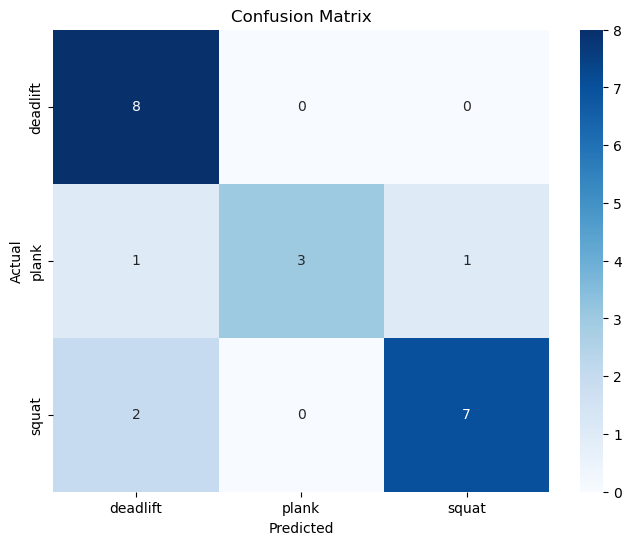

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoding back to labels

# Print classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=encoder.classes_))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



Use markdown cells like this one to include:
- Discussion points.
- References to specific sources of code that you might have used to solve the assignment.
- General commentas and explanations about your solution.

In [ ]:
# Always use comments in the code to document specific steps

## Task 2: This is the title of task 2

This section should contain the solution of task 2.

## Results and Discussion

In [ ]:
# Always use comments in the code to document specific steps

This section should contain:
- Results.
- Summary of best model performance:
    - Name of best model file as saved in /models.
    - Relevant scores such as: accuracy, precision, recall, F1-score, etc.
- Key discussion points.